# Invalid Sample Detection

In [2]:
from scipy               import signal
from datetime            import datetime, timedelta
import matplotlib.pyplot as plt
import numpy             as np
import wfdb
import scipy.fftpack
import scipy
import math
import parameters

%matplotlib inline
%config IPCompleter.greedy=True

We check that the signal is valid by examining the signal amplitude in an invalid frequency range, looking at various statistical properties, etc. 

## Invalid frequency signal amplitude

### Filter analysis

We make a bandpass filter on the range 70-90 Hz and check the signal amplitude in this range. If the signal amplitude exceeds limits, the data is marked as invalid.

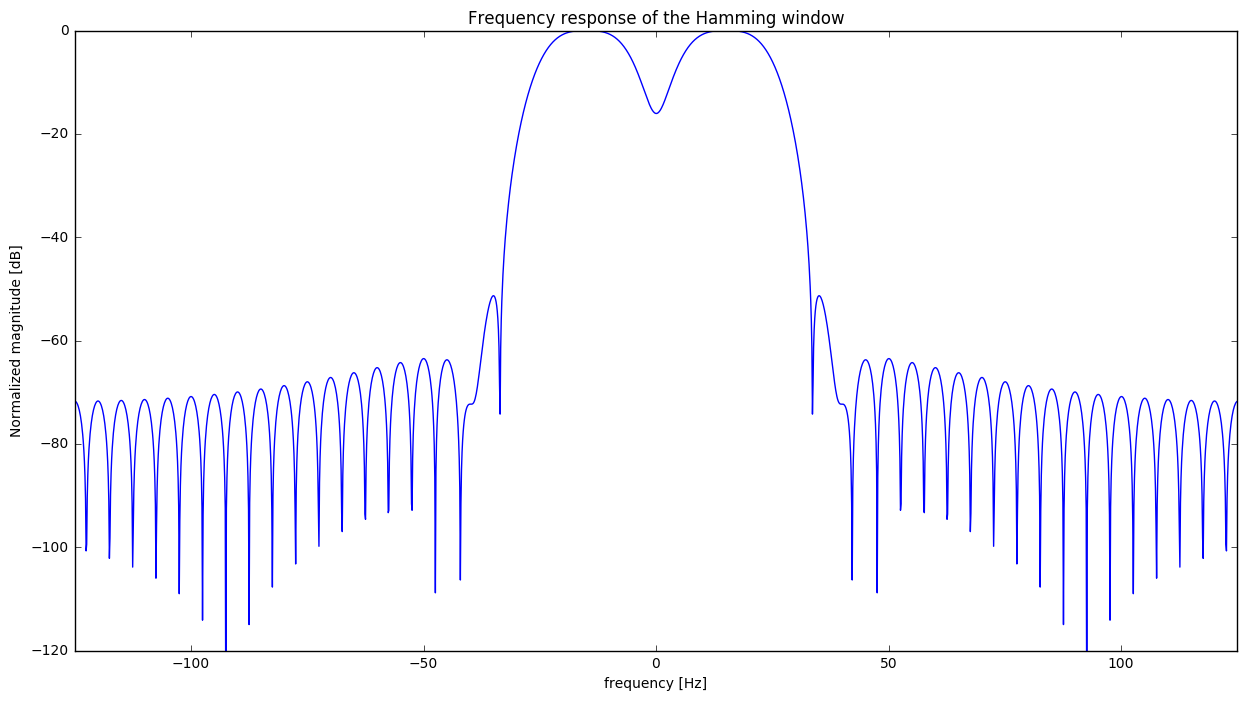

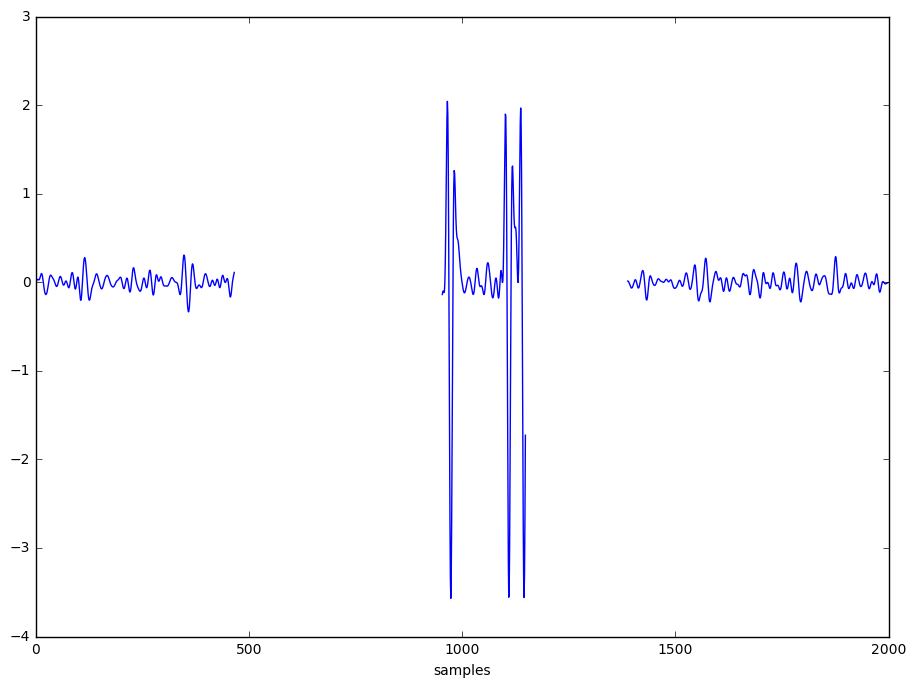

In [3]:
order = 50
f_low = 5
f_high = 25

def band_pass_filter(signal, f_low, f_high, order): 
    window = scipy.signal.firwin(order+1, [f_low, f_high], nyq=np.floor(fs/2), pass_zero=False,
                  window='hamming', scale=False)
    A = scipy.fftpack.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
    
#     plt.figure(figsize=[15,8])
#     plt.plot(fs*freq, response)
#     plt.axis([-fs*0.5, fs*0.5, -120, 0])
#     plt.title("Frequency response of the Hamming window")
#     plt.ylabel("Normalized magnitude [dB]")
#     plt.xlabel("frequency [Hz]")
#     plt.show()

    if np.size(signal) < 153: 
        return
    return scipy.signal.filtfilt(window, 1, signal)

sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
fs = 250
start = 292
end = 300
duration = end - start

a170s_signal = sig[start*fs:end*fs,:]
filtered_a170s_signal = band_pass_filter(a170s_signal[:,1], f_low, f_high, order)
    
# plot the data 
plt.figure(figsize=[11,8])
# plt.plot(a170s_signal[:,1],'r-')
plt.plot(filtered_a170s_signal,'b-')
plt.xlabel('samples')
plt.show()

In [20]:
cutoff = parameters.AMPL_CUTOFF
order = parameters.ORDER

# Check if amplitude within invalid range is above acceptable amplitudes
def is_amplitude_within_cutoff(signal, f_low, f_high, cutoff, order):  
    filtered_signal = band_pass_filter(signal, f_low, f_high, order)
    if filtered_signal is not None: 
        # Return False if any value in the filtered_signal is greater than cutoff
        return not (filtered_signal > cutoff).any()
    return True

print is_amplitude_within_cutoff(a170s_signal[:,1], f_low, f_high, cutoff, order)

True


## Statistical analysis

In [21]:
# Check signal statistics to be within minimum and maximum values
def check_stats_within_cutoff(signal, channel_type, stats_cutoffs): 
    signal_min = np.amin(signal)
    signal_max = np.amax(signal)
    var_range = signal_max - signal_min
    channel_stats_cutoffs = stats_cutoffs[channel_type]
    
    # Check minimum and maximum signal values
    if signal_min < channel_stats_cutoffs["val_min"] or signal_max > channel_stats_cutoffs["val_max"]: 
        return False
    
    # Check signal range in value
    if var_range > channel_stats_cutoffs["var_range_max"] or var_range < channel_stats_cutoffs["var_range_min"]: 
        return False
    
    return True

## Other metrics

### NaN test

In [22]:
# Check if signal contains NaN values
def contains_nan(signal): 
    return np.isnan(signal).any()

### Histogram test

In [23]:
# Check borders between histogram buckets so the difference is within a cutoff value
def histogram_test(signal, histogram_cutoff): 
    top_percentile = np.percentile(signal, parameters.TOP_PERCENTILE)
    bottom_percentile = np.percentile(signal, parameters.BOTTOM_PERCENTILE)
    
    # Filter out top and bottom 1% for data on which to generate histogram
    adjusted_signal = signal[(signal >= bottom_percentile) & (signal <= top_percentile)]
    
    # Generate histogram with 10 buckets by default
    histogram = np.histogram(adjusted_signal)[0]
    
    # Calculate frequency diffs between neighboring buckets and return True if all diffs within cutoff
    diffs = np.diff(histogram)
    return not (diffs > histogram_cutoff).any()

## Putting it all together

In [8]:
def get_channel_type(channel_name): 
    channel_types_dict = {}
    with open("sample_data/sigtypes", "r") as f: 
        for line in f: 
            splitted_line = line.split("\t")
            channel = splitted_line[-1].rstrip()
            channel_type = splitted_line[0]
            channel_types_dict[channel] = channel_type
    
    if channel_name in channel_types_dict.keys(): 
        return channel_types_dict[channel_name]
    
    raise Exception("Unknown channel name")
        
    
# Return list of channel indices for channels of type channel_type
def get_channels_of_type(channels, channel_type): 
    channel_indices = np.array([])
    
    for channel_index in range(len(channels)): 
        channel_name = channels[channel_index]
        if channel_type == get_channel_type(channel_name): 
            channel_indices = np.append(channel_indices, channel_index)
    
    return channel_indices


# Get start and end points (in seconds) to check depending on type of alarm signaled
def get_start_and_end(fields): 
    alarm_type = fields['comments'][0]
    if alarm_type not in parameters.TESTED_BLOCK_LENGTHS: 
        raise Exception("Unrecognized alarm type")
    tested_block_length = parameters.TESTED_BLOCK_LENGTHS[alarm_type]
    
    end = parameters.ALARM_TIME # in seconds, alarm always sounded at 300th second
    start = end - tested_block_length # in seconds
    
    return (start, end, tested_block_length)

In [25]:
# Returns whether signal is valid or not
def is_valid(signal, channel_type, f_low, f_high, histogram_cutoff, freq_amplitude_cutoff, stats_cutoffs, order,
            should_check_nan=True): 
    if channel_type == "Resp": 
        return True
    
    # Checks which return True if passing the test, False if not
    histogram_check = histogram_test(signal, histogram_cutoff)
    stats_check = check_stats_within_cutoff(signal, channel_type, stats_cutoffs)
    checks = np.array([histogram_check, stats_check])
    
    if should_check_nan: 
        nan_check = !contains_nan(signal)
        checks = np.append(checks, nan_check)
    
    # If ECG signal, also check signal amplitude in frequency range within limits
    if channel_type == "ECG": 
        signal_amplitude_check = is_amplitude_within_cutoff(signal, f_low, f_high, freq_amplitude_cutoff, order)
        checks = np.append(checks, signal_amplitude_check)
    
    return all(checks)


# Return invalids list given sig for a single channel
def calculate_channel_invalids(channel_sig,
                               channel_type,
                               should_check_nan=True,
                               fs=parameters.DEFAULT_ECG_FS,
                               block_length=parameters.BLOCK_LENGTH, 
                               order=parameters.ORDER,
                               f_low=parameters.F_LOW,
                               f_high=parameters.F_HIGH,
                               hist_cutoff=parameters.HIST_CUTOFF,
                               ampl_cutoff=parameters.AMPL_CUTOFF,
                               stats_cutoffs=parameters.STATS_CUTOFFS): 
    invalids = np.array([])
    start = 0 # in sample number
    
    # Check validity of signal for each block_length-long block
    while start < len(channel_sig): 
        signal = channel_sig[int(start):int(start + block_length*fs)]
        start += (block_length * fs)

        is_data_valid = is_valid(signal, channel_type, f_low, f_high, hist_cutoff, ampl_cutoff, stats_cutoffs, order, should_check_nan)
        
        if is_data_valid: 
            invalids = np.append(invalids, 0)
        else: 
            invalids = np.append(invalids, 1)
    
    return invalids

    
# Returns invalids dictionary mapping each channel to an invalids array representing validity of 0.8 second blocks
# Takes in sig and fields after already reading the sample file
def calculate_invalids_sig(sig, fields,
                           start=None,
                           end=None,
                           should_check_nan=True,
                           block_length=parameters.BLOCK_LENGTH, 
                           order=parameters.ORDER,
                           f_low=parameters.F_LOW,
                           f_high=parameters.F_HIGH,
                           hist_cutoff=parameters.HIST_CUTOFF,
                           ampl_cutoff=parameters.AMPL_CUTOFF,
                           stats_cutoffs=parameters.STATS_CUTOFFS): 
    
    channels = fields['signame']
    fs = fields['fs']
    if start is None or end is None: 
        start, end, alarm_duration = get_start_and_end(fields)
    window_start, window_end = start * fs, end * fs # in sample number
    
    invalids = {}
    
    # Generate invalids array for each channel 
    for channel_num in range(len(channels)): 
        start = window_start
        channel_name = channels[channel_num]
        channel_type = get_channel_type(channel_name)
        channel_sig = sig[:,channel_num]
        
        invalids_array = calculate_channel_invalids(channel_sig, channel_type, should_check_nan)
        invalids[channel_name] = invalids_array
                 
    return invalids


# Returns invalids dictionary given a sample name, start, and end
def calculate_invalids(sample, start, end,
                       should_check_nan=True,
                       block_length=parameters.BLOCK_LENGTH, 
                       order=parameters.ORDER,
                       f_low=parameters.F_LOW,
                       f_high=parameters.F_HIGH,
                       hist_cutoff=parameters.HIST_CUTOFF,
                       ampl_cutoff=parameters.AMPL_CUTOFF,
                       stats_cutoffs=parameters.STATS_CUTOFFS):
    sig, fields = wfdb.rdsamp(sample)
    return calculate_invalids_sig(sig, fields, start, end, should_check_nan)


# Calculate overall c_val of invalids list for a single channel (0 = invalid, 1 = valid)
def calculate_cval_channel(channel_invalids): 
    if len(channel_invalids) > 0: 
        return 1 - float(sum(channel_invalids)) / len(channel_invalids)
    return None
    

# Calculate overall c_val of invalids dictionary with all channels (0 = invalid, 1 = valid)
def calculate_cval(invalids): 
    cvals = {}
    for channel_name in invalids.keys(): 
        channel_invalids = invalids[channel_name]
        cvals[channel_name] = calculate_cval_channel(channel_invalids)
    return cvals

In [26]:
if __name__ == '__main__':
    # sample = 'sample_data/challenge_training_data/a170s'
    sample = 'sample_data/challenge_training_data/t209l'
    sig, fields = wfdb.rdsamp(sample)
    
    start = 295 # in seconds
    end = 300 # in seconds
    
    invalids = calculate_invalids_sig(sig, fields, start, end)
    print calculate_cval(invalids)

{'I': 1.0, 'ABP': 1.0, 'RESP': 1.0, 'MCL': 1.0}


## Appendix: not super relevant but nice to keep

### FFT analysis

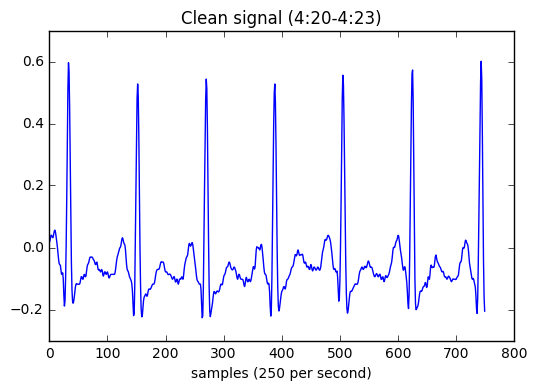

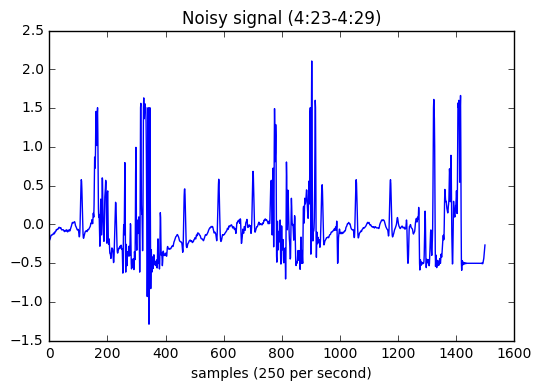

In [19]:
# There is a noisy section of this signal - between 4:20 and 4:25 (260 and 265 seconds)
sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a103l')
fs = 250
clean_start = 260
clean_end = 263
clean_duration = clean_end - clean_start

noisy_start = 263
noisy_end = 269
noisy_duration = noisy_end - noisy_start

clean_signal = sig[clean_start*fs:clean_end*fs,:]
noisy_signal = sig[noisy_start*fs:noisy_end*fs,:]

plt.plot(clean_signal[:,0],'b-')
plt.title('Clean signal (4:20-4:23)')
plt.xlabel('samples (250 per second)')
plt.show()

plt.title('Noisy signal (4:23-4:29)')
plt.plot(noisy_signal[:,0],'b-')
plt.xlabel('samples (250 per second)')
plt.show()

To check if the signal amplitude in the range 70-90 Hz is outsize the limits (> 0.005 mV), we look at the fft of the signal:  

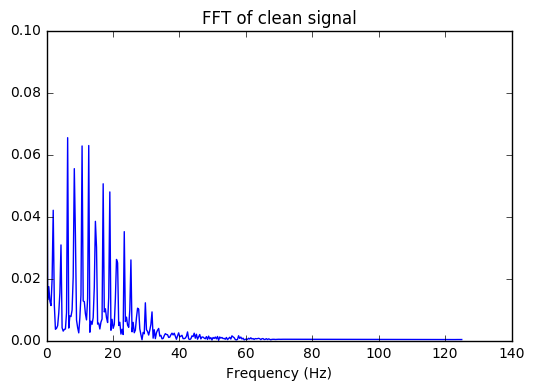

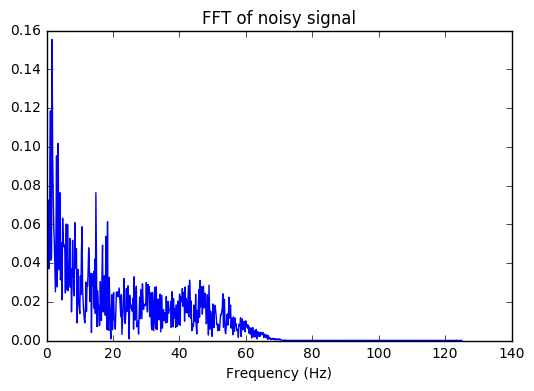

In [20]:
def get_signal_fft(signal, signal_duration, fs): 
    # Number of samplepoints
    N = signal_duration * fs
    # sample spacing
    T = 1.0 / fs
    
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
    signal_fft = scipy.fftpack.fft(signal)
    
    return (xf, 2.0/N * np.abs(signal_fft[:N/2]))
    
def plot_signal_fft(signal_xf, signal_fft, title=""):
    fig, ax = plt.subplots()
    ax.plot(signal_xf, signal_fft)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.show()

fs = 250
clean_xf, clean_signal_fft = get_signal_fft(clean_signal[:,0], clean_duration, fs)
noisy_xf, noisy_signal_fft = get_signal_fft(noisy_signal[:,0], noisy_duration, fs)
plot_signal_fft(clean_xf, clean_signal_fft, "FFT of clean signal")
plot_signal_fft(noisy_xf, noisy_signal_fft, "FFT of noisy signal")

In [26]:
noisy_amplitude_limit = 0.005

def get_fft_amplitude(signal_fft, frequency, signal_duration): 
    return signal_fft[frequency * signal_duration]

def check_frequency_amplitude_limits(signal_fft, signal_duration): 
    for frequency in range(70, 91): 
        if get_fft_amplitude(signal_fft, frequency, signal_duration) > noisy_amplitude_limit: 
            return "Invalid data"
    return "Valid data"
    
# print check_frequency_amplitude_limits(clean_signal_fft, clean_duration)
# print check_frequency_amplitude_limits(noisy_signal_fft, noisy_duration)

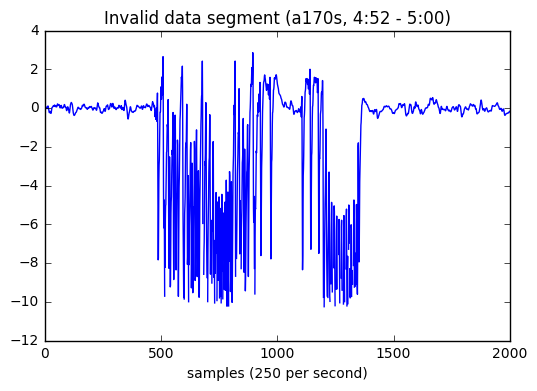

In [27]:
sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
fs = 250
start = 292
end = 300
duration = end - start

a170s_signal = sig[start*fs:end*fs,:]

plt.plot(a170s_signal[:,1],'b-')
plt.title('Invalid data segment (a170s, 4:52 - 5:00)')
plt.xlabel('samples (250 per second)')
plt.show()

xf, signal_fft = get_signal_fft(a170s_signal, duration, 1)
# plot_signal_fft(xf, signal_fft)
# print check_frequency_amplitude_limits(signal_fft, duration)

Putting this all together to visualize the raw signal, the filtered signal, and the FFT of the signal: 

In [28]:
# sig, fields=wfdb.rdsamp('sample_data/challenge_training_data/a170s')
# print fields['signame']
# fs = 250
# clean_start = 260
# clean_end = 263
# channel = 3
# clean_duration = clean_end - clean_start

# clean_signal = sig[clean_start*fs:clean_end*fs,:]

# plt.plot(clean_signal[:,channel],'b-')
# plt.xlabel('samples (250 per second)')
# plt.show()

# filtered_clean_signal = band_pass_filter(clean_signal[:,channel], 70, 90, 50)

# # plt.plot(clean_signal[:,channel],'r-')
# plt.plot(filtered_clean_signal,'b-')
# plt.xlabel('samples')
# plt.show()

# xf, signal_fft = get_signal_fft(clean_signal, clean_duration, channel)
# plot_signal_fft(xf, signal_fft, "FFT of clean signal")